# _*Deploying circuits: from virtual qubits to pulse schedules*_

<br>

***
<br>

### Author
Steve Jeffrey<sup></sup>

Email: <i>stephen_j_jeffrey@yahoo.com.au</i>
$$
   \newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
   \newcommand{\ket}[1]{\left|{#1}\right\rangle}
   \newcommand{\bra}[1]{\left\langle{#1}\right|}
   \newcommand{\rpm}{\raisebox{.2ex}{$\scriptstyle\pm$}}
$$

In [1]:
%%javascript
// This enables line numbers in LaTeX equations
// Please note, you may need to enter and exit edit mode in the mark down 
// cells and then run them, for the equation numbers to display correctly
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

This notebook provides an introduction to the sequence of operations involved in executing a circuit, once you have constructed your circuit using the tools in Qiskit. We will look at the following steps:
1. transpiling the circuit
2. conversion of gates to pulse schedules
3. optimisation of pulse schedules.

For an overview of these methods, you may wish to review Qiskit's [advanced tutorials](https://qiskit.org/documentation/tutorials.html#advanced-circuits). 

### Initialisation

In [2]:
# The codes in this notebook are adapted from various Qiskit codes (see
# the codes in Terra) and tutorials. Qiskit codes are licensed under 
# the Apache License, Version 2.0, © Copyright IBM 2018, 2020.

import math
import numpy as np
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager, passes
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import Unroller
from qiskit import transpile, pulse, schedule as build_schedule
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.tools.visualization import dag_drawer
from qiskit.test.mock import FakeTokyo, FakeTenerife, FakeMelbourne, FakeAlmaden
from qiskit.visualization.pulse_v2 import draw, IQXSimple, IQXStandard, IQXDebugging
from qiskit.visualization.exceptions import VisualizationError

# Helper function for displaying plots
import matplotlib.pyplot as plt
%matplotlib inline
def show_figure(fig):
    """
       Function outputs the given matplotlib plot
    """
    new_fig = plt.figure()
    new_mngr = new_fig.canvas.manager
    new_mngr.canvas.figure = fig
    fig.set_canvas(new_mngr.canvas)
    plt.show(fig)

# Style only works in matplotlib backend
style = {'backgroundcolor': 'lightgreen'}

# Select the device to use
#backend = FakeTokyo()
backend = FakeAlmaden()
if backend.configuration().open_pulse != True:
    print("Warning: the {:s} device does not support OpenPulse. Some parts\n"
          "         of this tutorial will not work.".format(backend.configuration().backend_name))

### Step 1. Construct the circuit

We will construct an arbitrary circuit consisting of:
1. a gate which has a native implementation on the device (controlled-$X$)
2. a parameterised gate which does not have a native implementation on the device ($R_x$)
3. a gate constructed from a unitary matrix (Hadamard).

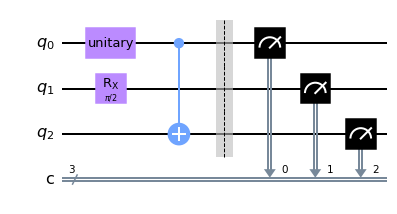

In [3]:
num_bits = 3
circ = QuantumCircuit(num_bits, num_bits, name='Circuit with H, CX and Rx')
# Construct a Hadamard gate
# - the Operator method is being used simply for demonstration purposes
c = 1.0 / math.sqrt(2.0)
H = Operator([[c, c],[c, -c]])
circ.append(H, [0])

# Insert the CNOT (controlled-X) gate
circ.cx(0, 2)

# Insert the parameterised RX
theta = Parameter('θ')
circ.rx(theta, 1)

# Measure
circ.barrier()
circ.measure([q for q in range(num_bits)], [c for c in range(num_bits)])

# Bind values to the parameter(s)
value = np.pi / 2.0
circuit = circ.bind_parameters({theta: value})

# Display the final circuit
circuit.draw(output='mpl')

### Step 1. Transpile the circuit

We will now transpile the circuit so it can be executed on the desired device. Transpilation typically involves a sequence of passes which:
1. convert the original circuit into a sequence of operations which are natively supported on the device.
<br>
The original circuit may consist of a range of unitary operations (gates) and non-gate operations which are not natively supported on the device. For example, $\texttt{backend.configuration().basis_gates}$ shows that the selected device does not natively support the Hadamard gate, so the transpiler will need to construct the equivalent gate using only those basis gates which are supported by the device.
<br>
<br>
2. maps the virtual qubits (in your circuit) to the physical qubits in the device
<br>
If the circuit contains multi-qubit operations and the physical qubits are not fully interconnected, the transpiler may need to swap the contents of the various qubits until the hardware connectivity allows the desired multi-qubit operation to proceed. Ideally the transpiler will choose the mapping which minimises the amount of swapping required, although such optimisation is far from trivial.
<br>
<br>
3. optimises the overall circuit.
<br>
The circuit may be transformed in various ways to reduce the impact of noise and gate errors. For example, it may be possible to combine successive rotations into a single rotation, thereby reducing the number of operations which can potentially degrade the accuracy of the end result. 

In the cell below we display the circuit after it has been "unrolled', using the basis gates available on our device. Unrolling has:
1. converted the Hadamard gate on qubit 0 to a $U_3(\frac{\pi}{2}, 0, \pi)$ gate
2. converted the $R_x(\frac{\pi}{2})$ gate on qubit 1 to a $U_3(\frac{\pi}{2}, -\frac{\pi}{2}, \frac{\pi}{2})$ gate,
where:
$$
\newcommand{\th}{\frac{\theta}{2}}
U_3(\theta, \phi, \lambda) =
            \begin{bmatrix}
                \cos(\th)          & -e^{i\lambda}\sin(\th) \\
                e^{i\phi}\sin(\th) & e^{i(\phi+\lambda)}\cos(\th)
            \end{bmatrix}.
$$

The above conversions can be verified given:
$$
\newcommand{\th}{\tfrac{\theta}{2}}
R_X(\theta) = e^{-i \th X} =
            \begin{bmatrix}
                \cos{\th}   & -i\sin{\th} \\
                -i\sin{\th} & \cos{\th}
            \end{bmatrix}
$$
and
$$
H = U_2(0, \pi) = U_3(\tfrac{\pi}{2}, 0, \pi).
$$

Device supports the following basis gates: ['id', 'u1', 'u2', 'u3', 'cx']


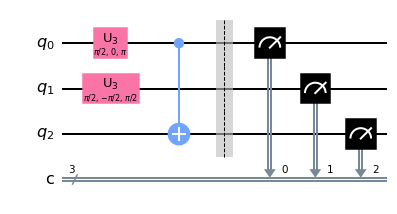

In [4]:
config = backend.configuration()

# Output the basis gates supported by this device
print("Device supports the following basis gates: {}".format(config.basis_gates))

test_pass = Unroller(config.basis_gates)
pm = PassManager(test_pass)
unrolled_circuit = pm.run(circuit)
unrolled_circuit.draw(output='mpl')

To assist in transforming the circuit and making it easier to track the flow of information, the transpiler may use a Directed Acyclic Graph (DAG) representation. You can view the DAG representation of your circuit as shown in the cell below.

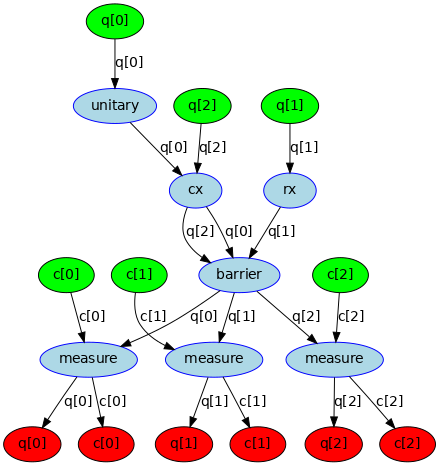

In [5]:
dag = circuit_to_dag(circuit)
dag_drawer(dag)

The DAG above is based on the original circuit. The cell below shows the DAG obtained after the circuit was unrolled.

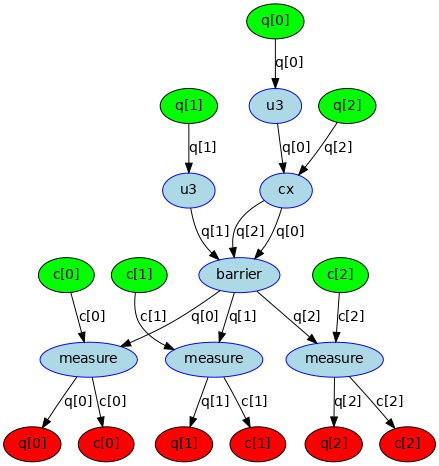

In [6]:
dag = circuit_to_dag(unrolled_circuit)
dag_drawer(dag)

Now that we have seen what basis gates will be used in the backend, we can examine the pulse schedules that will be applied to the physical qubits. To do this we transpile the circuit using the default pass manager, and then build the pulse schedule.

Backend timestep: 0.22222 ns
Pulse schedule duration: 6414.2 ns (28864.0 timesteps)
Figure 1 time range 0.0 - 444.4 ns (0.0 - 2000.0 timesteps)


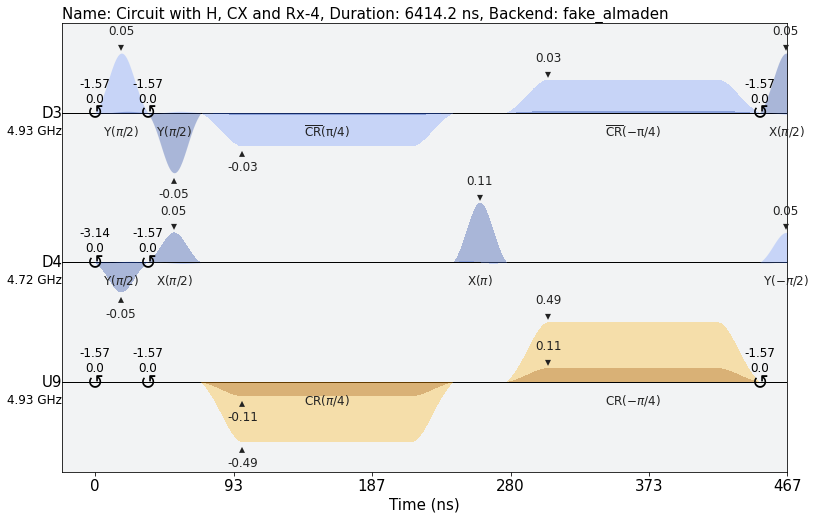

Figure 2 time range 444.4 - 888.9 ns (2000.0 - 4000.0 timesteps)


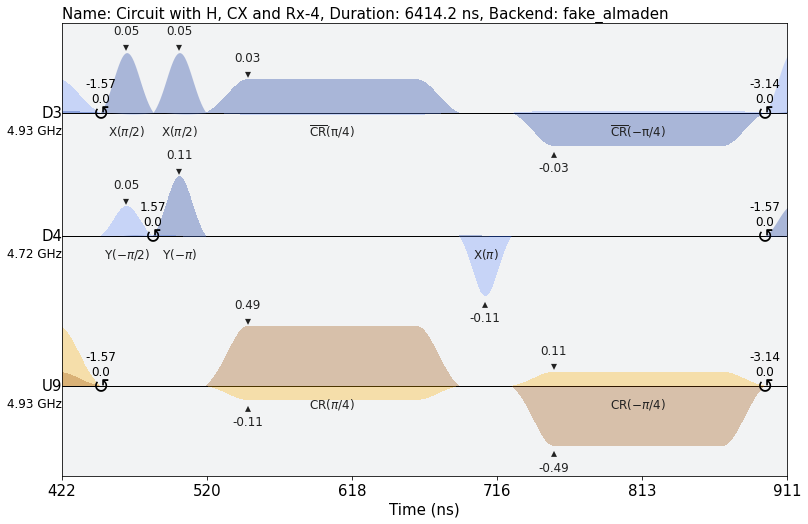

Figure 3 time range 888.9 - 1333.3 ns (4000.0 - 6000.0 timesteps)


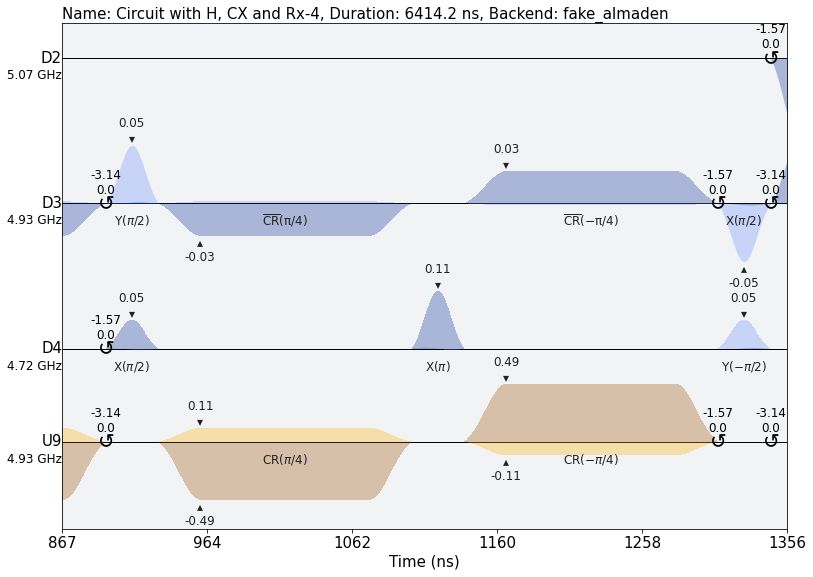

Figure 4 time range 1333.3 - 1777.8 ns (6000.0 - 8000.0 timesteps)


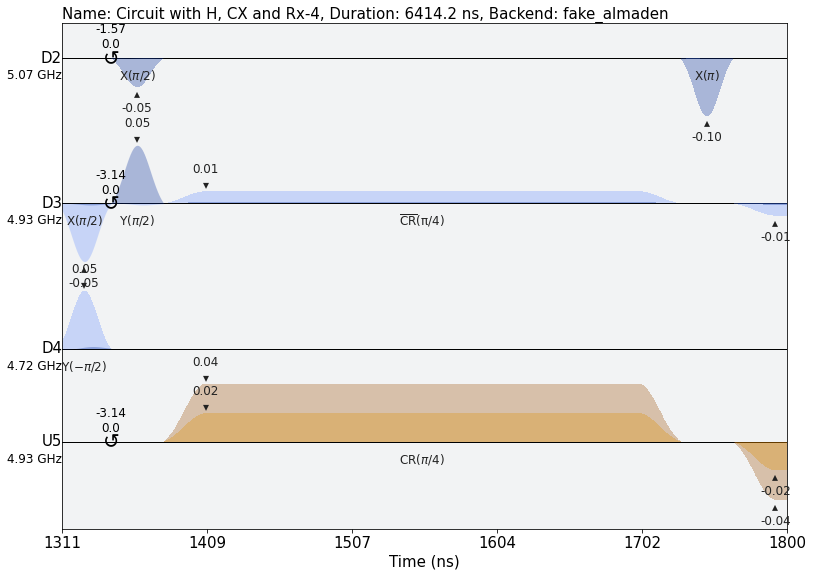

Figure 5 time range 1777.8 - 2222.2 ns (8000.0 - 10000.0 timesteps)


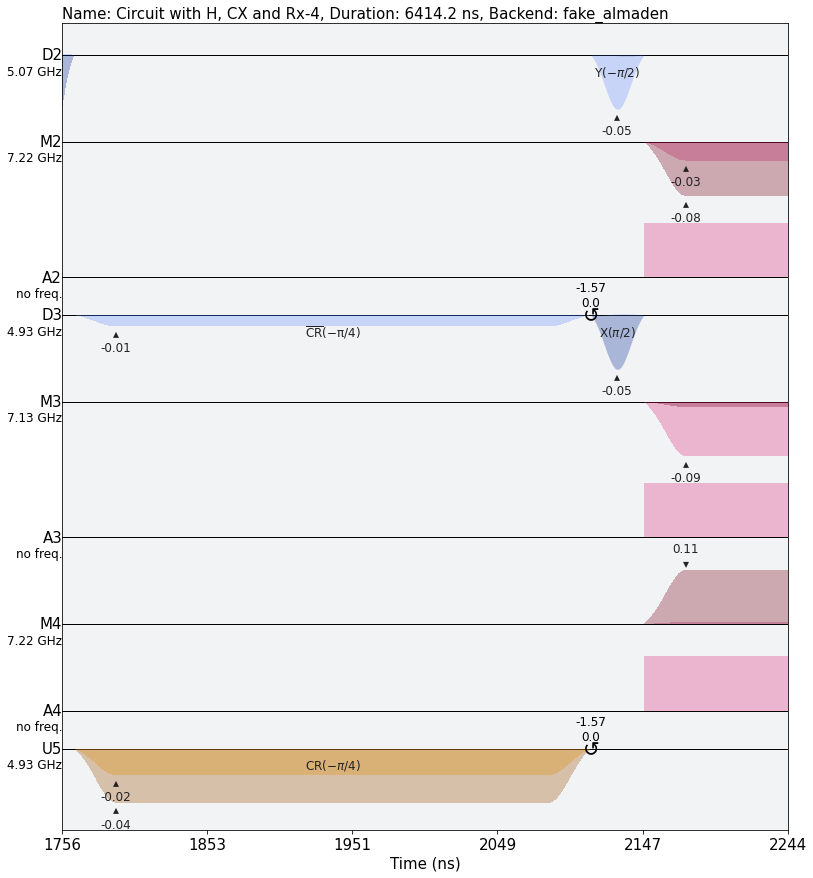

Figure 6 time range 2222.2 - 2666.7 ns (10000.0 - 12000.0 timesteps)


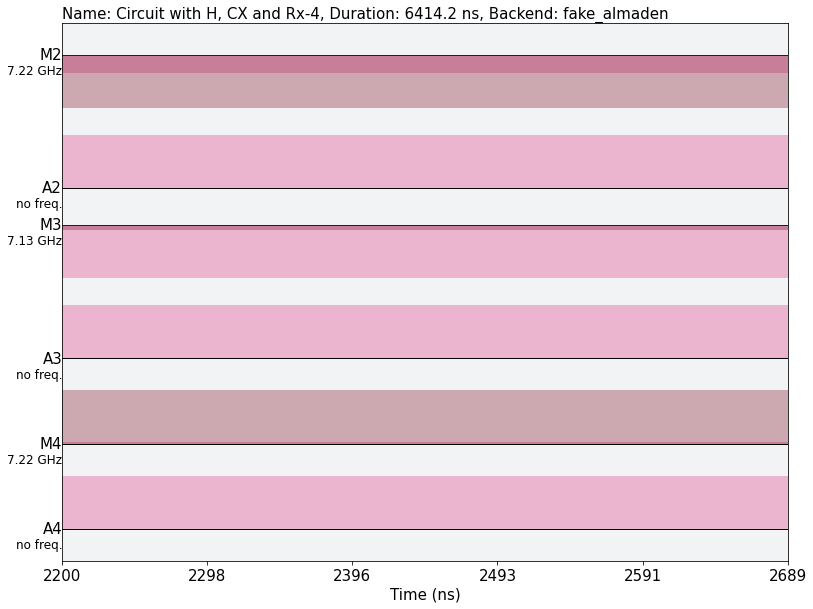

Figure 7 time range 2666.7 - 3111.1 ns (12000.0 - 14000.0 timesteps)
Could not draw schedule:  'Axis break is greater than time window. Nothing will be drawn.'
Figure 8 time range 3111.1 - 3555.6 ns (14000.0 - 16000.0 timesteps)
Could not draw schedule:  'Axis break is greater than time window. Nothing will be drawn.'
Figure 9 time range 3555.6 - 4000.0 ns (16000.0 - 18000.0 timesteps)
Could not draw schedule:  'Axis break is greater than time window. Nothing will be drawn.'
Figure 10 time range 4000.0 - 4444.4 ns (18000.0 - 20000.0 timesteps)
Could not draw schedule:  'Axis break is greater than time window. Nothing will be drawn.'
Figure 11 time range 4444.4 - 4888.9 ns (20000.0 - 22000.0 timesteps)
Could not draw schedule:  'Axis break is greater than time window. Nothing will be drawn.'
Figure 12 time range 4888.9 - 5333.3 ns (22000.0 - 24000.0 timesteps)
Could not draw schedule:  'Axis break is greater than time window. Nothing will be drawn.'
Figure 13 time range 5333.3 - 5777.8 

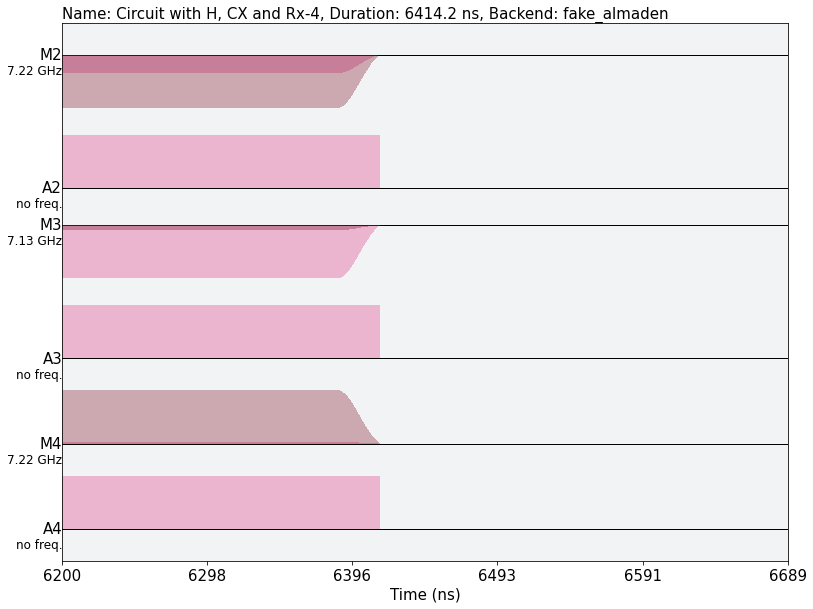

In [7]:
transpiled_circ = transpile(circuit, backend)
schedule = build_schedule(transpiled_circ, backend)
#schedule.draw(plot_range=[0, 15000])
style=IQXDebugging()
time_span=2000 # In units of dt
dt = backend.configuration().dt
print("Backend timestep: {:.5f} ns".format(dt * 1e9))
print("Pulse schedule duration: {:.1f} ns ({:.1f} timesteps)".format(
    schedule.duration*dt *1e9, schedule.duration))
for fig_no in range(int(schedule.duration/time_span)+1):
    print("Figure {:d} time range {:.1f} - {:.1f} ns ".format(
        fig_no+1,
        fig_no*time_span*dt *1e9, (fig_no+1)*time_span*dt *1e9)
        +
        "({:.1f} - {:.1f} timesteps)".format(
        fig_no*time_span, (fig_no+1)*time_span))
    try:
        show_figure(draw(schedule, style=style, backend=backend, 
                    time_range=(fig_no*time_span, (fig_no+1)*time_span)))
    except VisualizationError as e:
        print("Could not draw schedule: ", e)

Notes on viewing the pulse schedule:
- channels are labels for signal lines from the control hardware to the quantum chip.
- the circular arrows (*e.g.* $\circlearrowleft$ indicate a phase change (virtual Z gate).
- check the x-axis; it may be in units of time (ns) or timesteps.
- the channel labels are (see Alexander *et al* and the [*Qiskit tutorial*](https://qiskit.org/documentation/tutorials/circuits_advanced/06_building_pulse_schedules.html) for more details):
   - $d_i$ (drive channel): for transmitting drive pulses to qubit $i$, typically modulated at a frequency in resonance with qubit $i$. Drive channels are typically used for driving single qubit rotations.
   - $u_i$ (control channel): for transmitting signals typically associated with interaction terms in the system Hamiltonian (e.g. for implementing multi-qubit gates). Control channels are typically used for multi-qubit gates or additional drive lines for tunable qubits
   - $m_i$ (measure channel): for transmitting signals required to measure qubit $i$ *i.e* they stimulate readout.
   - $a_i$ (acquire channel): for receiving data from the readout component of qubit $i$ *i.e* they trigger digitizers which collect readout signals.
   
   The numbers below the channel labels are the amplitude scaling used for displaying the schedule.
- pulse envelopes in bright colours represent the real (in-phase) component of the input waveform
- pulse envelopes in dark colours represent the imaginary (quadrature-phase) component of the input waveform
- data acquisition triggers (on $a_i$ channels) are usually sychronized with measure signals (on $m_i$ channels).

1. [*Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses*](https://arxiv.org/abs/2004.06755), 
T. Alexander, N. Kanazawa, D. Egger, L. Capelluto, C.. Wood, A. Javadi-Abhari and D. McKay, Quantum Sci. Technol. 5 (2020) 044006, DOI: 10.1088/2058-9565/aba404.

To help us understand the pulse schedule, we will:
1. review the various standard gates and their implementation on IBM Quantum systems. 
2. examine the pulse schedule for various individual gates.

Most of the information has been extracted from the documentation in the Qiskit source files for each gate.

<br>

##### $U_3$ gate
Generic single-qubit rotation gate with 3 Euler angles:
\begin{eqnarray}
U_3(\theta, \phi, \lambda) &=&
        R_Z(\phi)\;.R_X(-\tfrac{\pi}{2})\;.R_Z(\theta)\;.R_X(\tfrac{\pi}{2})\;.R_Z(\lambda) \\
        &=&
            \begin{bmatrix}
                \cos(\th)          & -e^{i\lambda}\sin(\th) \\
                e^{i\phi}\sin(\th) & e^{i(\phi+\lambda)}\cos(\th) \nonumber
            \end{bmatrix}.
\end{eqnarray}
It is implemented using two X90 pulses on IBM Quantum systems (with phases changes used to implement three virtual $R_Z$ gates).

Example uses:
\begin{eqnarray}
        R_X(\theta) &=& U_3(\theta, -\tfrac{\pi}{2}, \tfrac{\pi}{2}) \nonumber \\
        R_Y(\theta) &=& U_3(\theta, 0, 0). \nonumber 
\end{eqnarray}

##### $U_2$ gate
Single-qubit rotation about the X+Z axis:
\begin{eqnarray}        
U_2(\phi, \lambda) &=& R_Z(\phi)\;.R_Y(\tfrac{\pi}{2})\;.R_Z(\lambda) \\
                  &=&\tfrac{1}{\sqrt{2}}
            \begin{bmatrix}
                1          & -e^{i\lambda} \nonumber \\
                e^{i\phi} & e^{i(\phi+\lambda)} \nonumber
            \end{bmatrix}.
\end{eqnarray}
It is implemented using one X90 pulse on IBM Quantum systems (with phases changes used to implement two virtual $R_Z$ gates).
    
Example uses:
\begin{eqnarray}
        H &=& U_2(0, \pi) \nonumber \\
        R_Y(\tfrac{\pi}{2}) &=& U_2(0, 0)  \nonumber \\
        R_X(\tfrac{\pi}{2}) &=& U_2(-\tfrac{\pi}{2}, \tfrac{\pi}{2}). \nonumber
\end{eqnarray}   

##### $U_1$ gate
Single-qubit rotation about the Z axis:
\begin{eqnarray}        
U_1(\lambda) =
            \begin{bmatrix}
                1 & 0 \\
                0 & e^{i\lambda}
            \end{bmatrix}.
\end{eqnarray}
It is implemented using a virtual Z gate (see McKay *et.al.* for details) on IBM Quantum systems.
A physical gate is not required as the rotation can be effected by a "frame change"
*i.e.* adjusting the phase.

Example uses:
\begin{eqnarray}
         Z &=& U_1(\lambda = \pi) \nonumber \\
         S &=& U_1(\lambda = \tfrac{\pi}{2}) \nonumber \\
         T &=& U_1(\lambda = \tfrac{\pi}{4}). \nonumber
\end{eqnarray}

Note: this gate is diagonal in the computational basis.
<br><br>
##### Hadamard gate
Single qubit $\pi$ rotation about the X+Z axis:
\begin{eqnarray}
H = \tfrac{1}{\sqrt{2}}
            \begin{bmatrix}
                1 & 1 \\
                1 & -1
            \end{bmatrix}.
\end{eqnarray}
It is implemented using one $U_2(0, \pi)$ gate on IBM Quantum systems.

Note: this gate has the effect of changing basis from the standard compututational
basis $\left\{\ket{0}, \ket{1}\right\}$ to the Hadamard basis $\left\{\ket{+}, \ket{-}\right\}$.

##### $X$ gate
Single-qubit Pauli X:
\begin{eqnarray}
X = \begin{bmatrix}
                0 & 1 \\
                1 & 0
    \end{bmatrix}.
\end{eqnarray}
It is implemented using one $U_3(\pi, 0, \pi)$ gate on IBM Quantum systems.

It is equivalent to the classical bit flip:
\begin{eqnarray}
   \ket{0} &\rightarrow& \ket{1} \nonumber \\
   \ket{1} &\rightarrow& \ket{0}. \nonumber             
\end{eqnarray}

Note: the X gate is:<br>
- equivalent to a $\pi$ rotation about the X axis
- related to $R_X(\pi)$ by a global phase: $R_X(\pi) = -i X$.

##### $Y$ gate
Single-qubit Pauli Y:
\begin{eqnarray}
Y = \begin{bmatrix}
                0 & -i \\
                i & 0
    \end{bmatrix}.
\end{eqnarray}
It is implemented using one $U_3(\pi, \tfrac{\pi}{2}, \tfrac{\pi}{2})$ gate on IBM Quantum systems.

It is equivalent to a bit and phase flip:
\begin{eqnarray}
   \ket{0} &\rightarrow& i\ket{1} \nonumber \\
   \ket{1} &\rightarrow& -i\ket{0}. \nonumber             
\end{eqnarray}

Note: the Y gate is:<br> 
- equivalent to a $\pi$ rotation about the Y axis.
- related to $R_Y(\pi)$ by a global phase: $R_Y(\pi) = -i Y$.

##### $Z$ gate
 Single-qubit Pauli Z:
\begin{eqnarray}
Z = \begin{bmatrix}
                1 & 0 \\
                0 & -1
    \end{bmatrix}.
\end{eqnarray}
It is implemented using one $U_1(\pi)$ gate on IBM Quantum systems.

It is equivalent to the phase flip:
\begin{eqnarray}
   \ket{0} &\rightarrow& \ket{0} \nonumber \\
   \ket{1} &\rightarrow& -\ket{1}. \nonumber             
\end{eqnarray}

Note: the Z gate is:<br>
- equivalent to a $\pi$ rotation about the Z axis
- related to $R_Z(\pi)$ by a global phase: $R_Z(\pi) = -Z$.

<br>

##### $R_X$ gate
Single-qubit rotation about the X axis:
\begin{equation}
\newcommand{\th}{\tfrac{\theta}{2}}
R_X(\theta) = e^{-i \th X} =
\begin{bmatrix}
                \cos{\th}   & -i\sin{\th} \\
                -i\sin{\th} & \cos{\th}
            \end{bmatrix}.
\end{equation}

##### $R_Y$ gate
Single-qubit rotation about the Y axis:
\begin{equation}
\newcommand{\th}{\frac{\theta}{2}}
R_Y(\theta) = e^{-i \th Y} =
            \begin{bmatrix}
                \cos{\th} & -\sin{\th} \\
                \sin{\th} & \cos{\th}
            \end{bmatrix}
\end{equation}

##### $R_Z$ gate
Single-qubit rotation about the Z axis:
\begin{equation}
R_Z(\lambda) = e^{-i\tfrac{\lambda}{2}Z} =
            \begin{bmatrix}
                e^{-i\frac{\lambda}{2}} & 0 \\
                0 & e^{i\frac{\lambda}{2}}
            \end{bmatrix}.
\end{equation}
<br>
It is implemented using a virtual Z gate (see McKay *et.al.* for details) on IBM Quantum systems.
A physical gate is not required as the rotation can be effected by a "frame change"
*i.e.* adjusting the phase.

Note: this gate is:
- diagonal in the computational basis
- related to $U_1(\lambda)$ by a global phase: $U_1(\lambda) = e^{i\tfrac{\lambda}{2}}R_Z(\lambda)$.

##### Controlled-$X$ gate
Two qubit gate which applies the X gate to the target qubit if the control qubit is in the 
$\ket{1}$ state:
\begin{equation}
\ket{a, b} \rightarrow \ket{a, a \oplus b\rangle}
\end{equation}
Notes:
- it is equivalent to the classical XOR gate
- the controlled-controlled X gate is known as the Toffoli gate.
<br>

##### Controlled-$Y$ gate
Two qubit gate which applies the Y gate to the target qubit if the control qubit is in the 
$\ket{1}$ state:
\begin{equation}
CY(0,1) = S^\dagger(1)\;.CX(0,1)\;.S(1)
\end{equation}
where $0,1$ denote the qubit indices.
<br>

##### Controlled-$Z$ gate
Two qubit gate which applies the Z gate to the target qubit if the control qubit is in the 
$\ket{1}$ state:
\begin{equation}
CZ(0,1) = H(1)\;.CX(0,1)\;.H(1)
\end{equation}
where $0,1$ denote the qubit indices.
<br>

##### SWAP gate
Two qubit gate which interchanges two qubits:
\begin{equation}
\ket{a,b} \rightarrow \ket{b,a}
\end{equation}
It is implemented using three $CNOT$ gates:
\begin{equation}
SWAP(a,b) = CX(0,1)\;.CX(1,0)\;.CX(0,1)
\end{equation}
where $0,1$ denote the qubit indices.
<br>

***Notes:***
- Rotations around the X and Y axes can be generated by modulating the coupling between the $\ket{0}$ and $\ket{1}$ states, at the frequency difference between the two states, given by: $\omega_{01} = \left(E_{\ket{1}} - E_{\ket{0}}\right)/\hbar$. The drive signal has form (see McKay *et.al.* for details):
$$
\Omega(t) \cos{\left(\omega_D t - \gamma\right)}
$$
where $\Omega(t)$ is the drive strength, $\omega_D$ is the drive frequency, and $\gamma$ is the phase.
  - the pulse duration is determined by the desired rotation angle and drive strength
  - for rotations about X, set $\gamma = 0$ (on resonance)
  - for rotations about Y, set $\gamma = \tfrac{\pi}{2}$.
- cross resonance can be used to implement multi-qubit gates. For example, a cross resonance entangling gate can be implemented by driving the *control* qubit (*e.g.* with a microwave pulse) at the frequency of the *target* qubit. The aim is to introduce a $ZX$ interaction term into the system Hamiltonian where $Z$ is the Pauli-Z operator on the (driven) control qubit, and $X$ is the Pauli-X operator on the target qubit. For further details, see Alexander *et al*.
<br>

1. [*Efficient Z-Gates for Quantum Computing*](https://arxiv.org/abs/1612.00858), D.C. McKay, C.J. Wood, S. Sheldon, J.M. Chow and J.M. Gambetta, Phys. Rev. A 96, 022330 (2017), DOI: 10.1103/PhysRevA.96.022330.
2. [*Qiskit Pulse: Programming Quantum Computers Through the Cloud with Pulses*](https://arxiv.org/abs/2004.06755), 
T. Alexander, N. Kanazawa, D. Egger, L. Capelluto, C.. Wood, A. Javadi-Abhari and D. McKay, Quantum Sci. Technol. 5 (2020) 044006, DOI: 10.1088/2058-9565/aba404.

Qubit 0: resonant frequency: 4.85649 GHz
---------------------- Hadamard gate: ----------------------
	Original circuit:


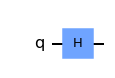

	Unrolled circuit:


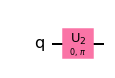

	Pulse schedule:


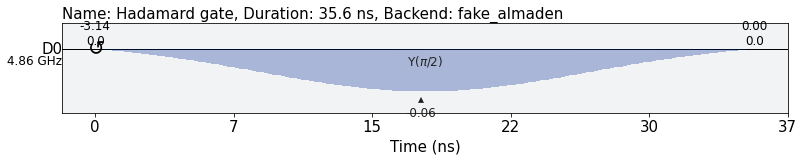

---------------------- X (bit flip) gate: ----------------------
	Original circuit:


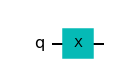

	Unrolled circuit:


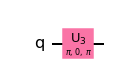

	Pulse schedule:


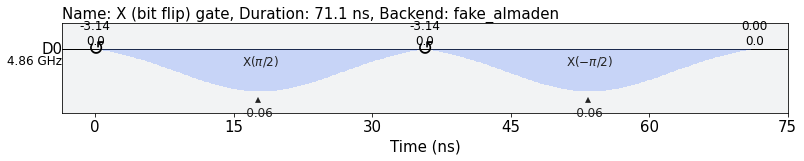

---------------------- Y (bit and phase flip) gate: ----------------------
	Original circuit:


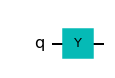

	Unrolled circuit:


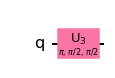

	Pulse schedule:


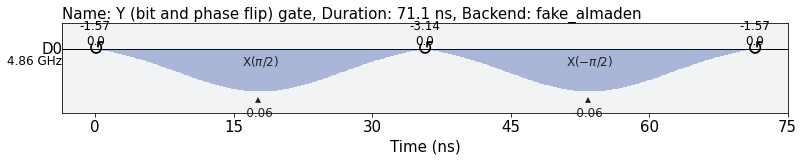

---------------------- Z (phase flip) gate: ----------------------
	Original circuit:


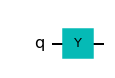

	Unrolled circuit:


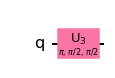

	Pulse schedule:


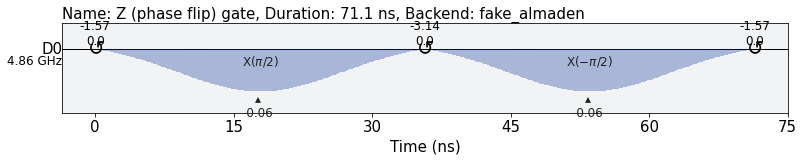

---------------------- X-rotation gate: ----------------------
	Original circuit:


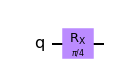

	Unrolled circuit:


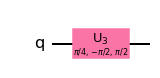

	Pulse schedule:


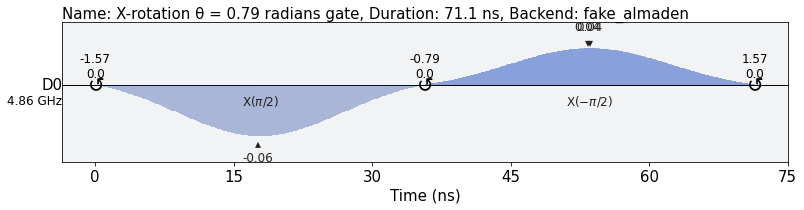

	Original circuit:


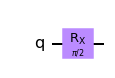

	Unrolled circuit:


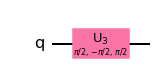

	Pulse schedule:


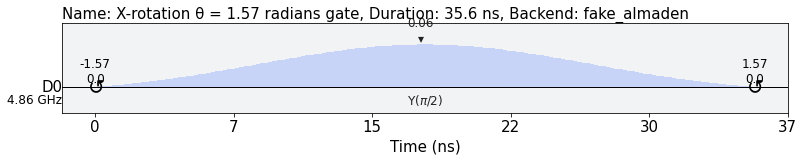

	Original circuit:


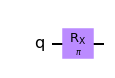

	Unrolled circuit:


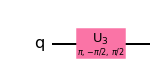

	Pulse schedule:


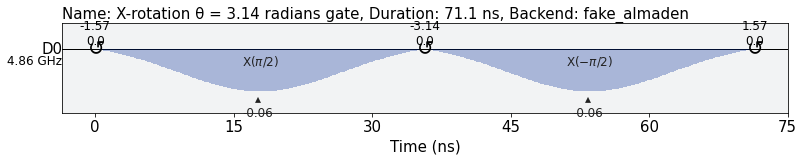

---------------------- Y-rotation gate: ----------------------
	Original circuit:


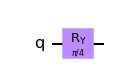

	Unrolled circuit:


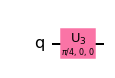

	Pulse schedule:


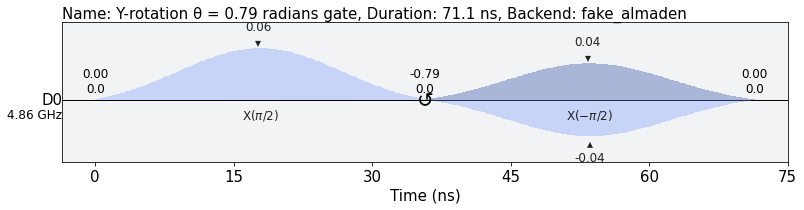

	Original circuit:


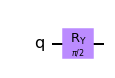

	Unrolled circuit:


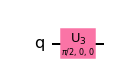

	Pulse schedule:


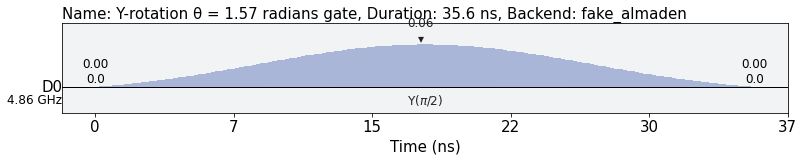

	Original circuit:


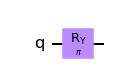

	Unrolled circuit:


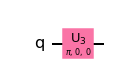

	Pulse schedule:


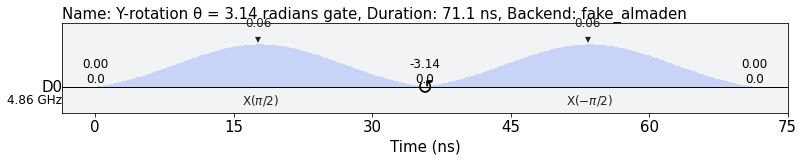

---------------------- CX gate: ----------------------
	Original circuit:


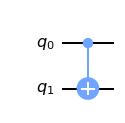

	Unrolled circuit:


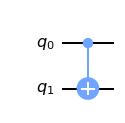

	Pulse schedule:


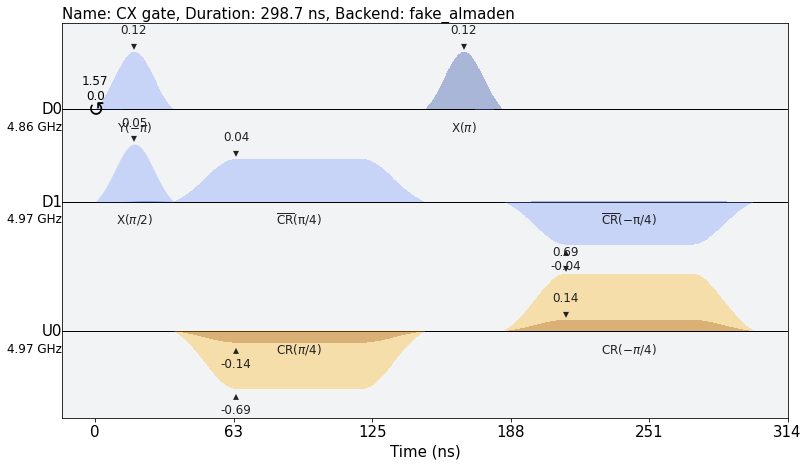

---------------------- CY gate: ----------------------
	Original circuit:


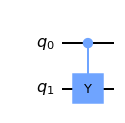

	Unrolled circuit:


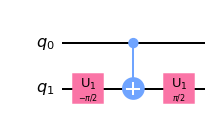

	Pulse schedule:


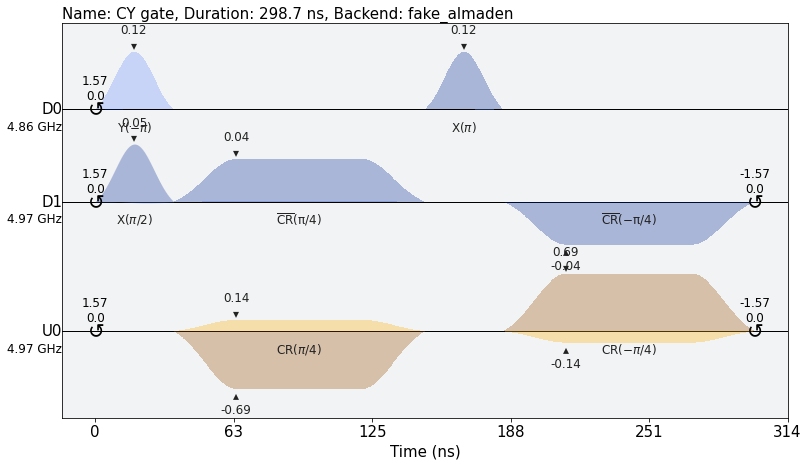

---------------------- CZ gate: ----------------------
	Original circuit:


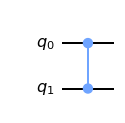

	Unrolled circuit:


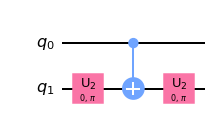

	Pulse schedule:


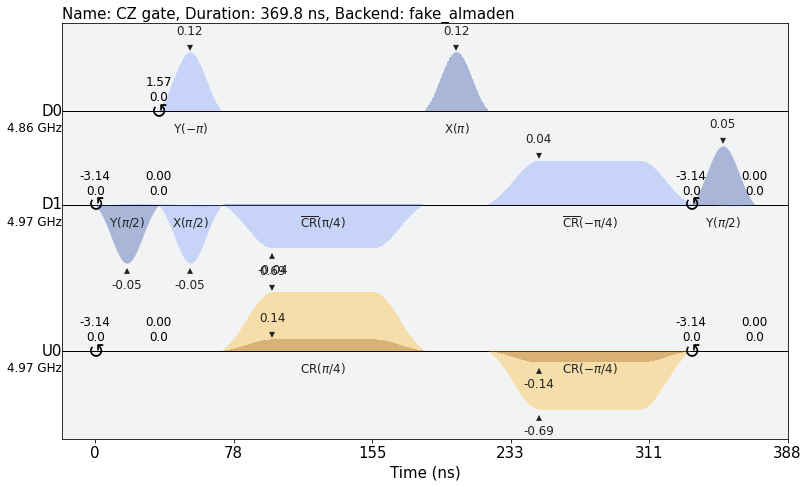

---------------------- SWAP gate: ----------------------
	Original circuit:


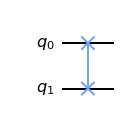

	Unrolled circuit:


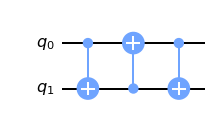

	Pulse schedule:


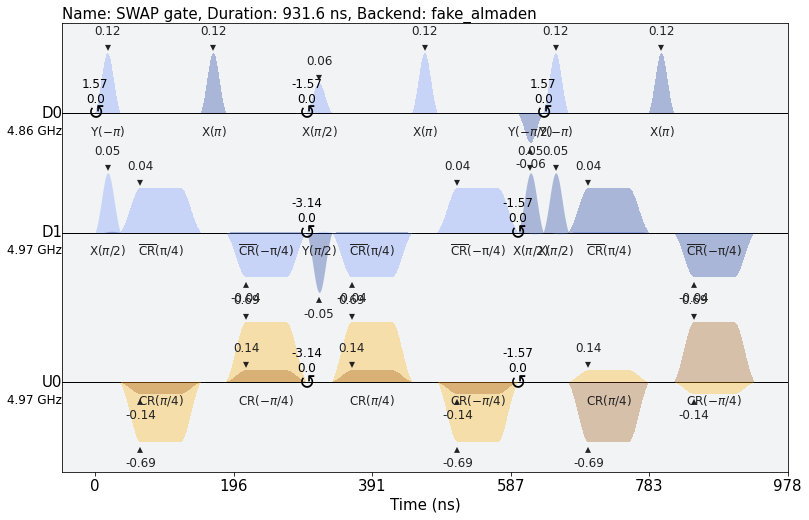

In [10]:
from qiskit.circuit.library.standard_gates import IGate, HGate,\
     XGate, YGate, ZGate, RXGate, RYGate, RZGate, SGate, TGate,\
     CXGate, CYGate, CZGate, SwapGate

# Style of pulse schedule plots
style=IQXDebugging()

# Device information
qubit = 0
GHz = 1.0e9
props = backend.properties()
print("Qubit 0: resonant frequency: {:.5f} GHz".format(
    props.frequency(qubit)/GHz))
# In pulse schedule plots:
# - light colours are for real component, dark colours for the imaginary component

# Loop over gates
#'Z': ZGate(),
#'Identity': IGate(),
for gate_name, gate in {
                        'Hadamard': HGate(), 
                        'X (bit flip)': XGate(),
                        'Y (bit and phase flip)': YGate(),
                        'Z (phase flip)': YGate(),
                        'X-rotation': RXGate(0.0),
                        'Y-rotation': RYGate(0.0),
                        'CX': CXGate(),
                        'CY': CYGate(),
                        'CZ': CZGate(),
                        'SWAP': SwapGate()
                       }.items():
    print("---------------------- {:s} gate: ----------------------".format(gate_name))
    
    # Set the parameters
    n_qubits = 1
    params = [0.0]         # Dummy parameter so the loop over parameters works for all gate types
    qubit_IDs_1 = [[0]]    # Qubit ID  for one-qubit gates
    qubit_IDs_2 = [[0, 1]] # Qubit IDs for two-qubit gates
    if isinstance(gate, RXGate) or isinstance(gate, RYGate) or isinstance(gate, RZGate):
        # We will display the pulse schedules for the following rotation angles
        params = [np.pi/4, np.pi/2, np.pi]     
    elif isinstance(gate, CXGate) or isinstance(gate, CYGate) or \
        isinstance(gate, CZGate) or isinstance(gate, SwapGate):
        n_qubits = 2 
               
    for p in params:
        # Create the circuit with the required number of qubits
        c = QuantumCircuit(n_qubits, name=gate_name)
        
        # Set the parameters
        if isinstance(gate, RXGate):
            # Create a new RX gate with the correct rotation angle
            gate = RXGate(p)
            gate_name_long = gate_name + " θ = {:.2f} radians".format(p)
        elif isinstance(gate, RYGate):
            gate = RYGate(p)
            gate_name_long = gate_name + " θ = {:.2f} radians".format(p)
        elif isinstance(gate, RZGate):
            gate = RZGate(p)
            gate_name_long = gate_name + " θ = {:.2f} radians".format(p)
        else:
            gate_name_long = gate_name
        
        # Append the gate to the circuit
        if isinstance(gate, CXGate) or isinstance(gate, CYGate) or \
            isinstance(gate, CZGate) or isinstance(gate, SwapGate):
            c.append(gate, *qubit_IDs_2)
        else:
            c.append(gate, *qubit_IDs_1)
                  
        # Display the circuit
        print("\tOriginal circuit:")
        show_figure(c.draw(output='mpl'))
        # Unroll to basis gates
        unroller = Unroller(backend.configuration().basis_gates)
        p = PassManager(unroller)
        unrolled_c = p.run(c)
        # Display the unrolled circuit
        print("\tUnrolled circuit:")
        show_figure(unrolled_c.draw(output='mpl'))
        # Transpile and display the pulse schedule
        transpiled_c = transpile(c, backend, output_name=gate_name_long + " gate")
        schedule = build_schedule(transpiled_c, backend)
        print("\tPulse schedule:")
        show_figure(draw(schedule, style=style, backend=backend))
        # Clean up
        del c


The above schedules are those that are implemented, which may differ slightly from the definitions given above. To demonstrate the equivalence, we will examine the $R_x(\tfrac{\pi}{4})$ gate. According to the above definition:
\begin{equation}
        R_X(\theta) = U_3(\theta, -\tfrac{\pi}{2}, \tfrac{\pi}{2})
\end{equation}
which can be implemented using $R_X$ and $R_Z$ gates as follows:
\begin{equation}
        R_Z(-\tfrac{\pi}{2})\;.R_X(-\tfrac{\pi}{2})\;.R_Z(\theta)\;.R_X(\tfrac{\pi}{2})\;.R_Z(\tfrac{\pi}{2}).
\end{equation}
However, the pulse schedule (see the above plot) shows the IBM system uses the following gate sequence to implement $R_x(\tfrac{\pi}{4})$:
\begin{equation}
\label{qiskit_schedule}
        R_Z(\tfrac{\pi}{2})\;.R_X(-\tfrac{\pi}{2})\;.R_Z(-\tfrac{\pi}{4})\;.R_X(\tfrac{\pi}{2})\;.R_Z(-\tfrac{\pi}{2})
\end{equation}
while McKay *et al* uses the sequence:
\begin{equation}
\label{mackay_schedule}
        R_Z(-\tfrac{\pi}{2})\;.R_X(\tfrac{\pi}{2})\;.R_Z(\tfrac{3\pi}{4})\;.R_X(\tfrac{\pi}{2})\;.R_Z(-\tfrac{\pi}{2}).
\end{equation}
We can use circuit identities to show that the various schedules are equivalent. For example, the two schedules in Equations \ref{qiskit_schedule} and \ref{mackay_schedule} can be shown to be equivalent using the identity:
\begin{equation}
        R_Z(\pi) = R_X(\tfrac{\pi}{2})\;.R_Z(\pi)\;.R_X(\tfrac{\pi}{2}).
\end{equation}
